In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import StratifiedKFold
#from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pickle
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dheer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
data = pd.read_csv(r"Amazon_Alexa.tsv", delimiter = '\t',)

In [47]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [48]:
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [49]:
data[data['verified_reviews'].isna() == True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [50]:
data.dropna(inplace=True)

In [51]:
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    0
feedback            0
dtype: int64

In [52]:
data['length'] = data['verified_reviews'].apply(len)

In [53]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [54]:
data.describe()

,rating,feedback,length
count,3149.000000,3149.000000,3149.000000
mean,4.463957,0.918704,132.090187
std,1.067773,0.273332,182.114569
min,1.000000,0.000000,1.000000
25%,4.000000,1.000000,30.000000
50%,5.000000,1.000000,74.000000
75%,5.000000,1.000000,165.000000
max,5.000000,1.000000,2851.000000


In [55]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data.verified_reviews)

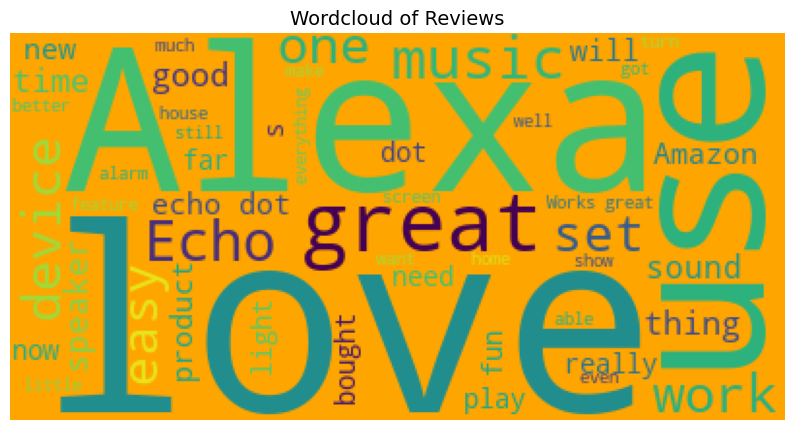

In [56]:
# Combine all reviews
reviews = " ".join([review for review in data['verified_reviews']])
                        
# Initialize wordcloud object
wc = WordCloud(background_color='orange', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud of Reviews', fontsize=14)
plt.axis('off')
plt.show()

Building the corpus from the 'verified_reviews', following these steps:

1. Replace any non-alphabetic characters with a space.
2. Convert the text to lowercase and split it into individual words.
3. Iterate over each word, and if it's not a stopword, add the stemmed version of the word to the corpus.

In [57]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

**Using Count Vectorizer to create bag of words**

In [58]:
cv = CountVectorizer(max_features = 2500)
X = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

In [59]:
#Saving the Count Vectorizer
pickle.dump(cv, open('Models/countVectorizer.pkl', 'wb'))

**Splitting data into train and test set with 30% data with testing**

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (2204, 2500)
y train: (2204,)
X test: (945, 2500)
y test: (945,)


**Scaling X_train and X_test so that all values are between 0 and 1**

In [61]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [62]:
pickle.dump(scaler, open('Models/scaler.pkl', 'wb'))

**Random Forest Classifier**

In [63]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

**Predicting on the test set<br>
Generating classification report<br>
Generating confusion matrix**

In [64]:
y_pred = model_rf.predict(X_test_scl)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.28      0.40        80
           1       0.94      0.99      0.96       865

    accuracy                           0.93       945
   macro avg       0.85      0.63      0.68       945
weighted avg       0.92      0.93      0.92       945

Confusion Matrix:
[[ 22  58]
 [  7 858]]


In [71]:
pickle.dump(scaler, open('Models/rf.pkl', 'wb'))


**XG-BOOST Classifier**

In [65]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

**Predicting on the test set<br>
Generating classification report<br>
Generating confusion matrix**

In [66]:
y_pred = model_xgb.predict(X_test_scl)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.30      0.40        80
           1       0.94      0.98      0.96       865

    accuracy                           0.92       945
   macro avg       0.77      0.64      0.68       945
weighted avg       0.91      0.92      0.91       945

Confusion Matrix:
[[ 24  56]
 [ 16 849]]


**Saving the XGBoost classifier**

In [67]:
pickle.dump(model_xgb, open('Models/model_xgb.pkl', 'wb'))

**Decision Tree Classifier**

In [68]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, y_train)

DecisionTreeClassifier()

**Predicting on the test set<br>
Generating classification report<br>
Generating confusion matrix**

In [69]:
y_pred = model_dt.predict(X_test_scl)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.46      0.51        80
           1       0.95      0.97      0.96       865

    accuracy                           0.92       945
   macro avg       0.76      0.71      0.73       945
weighted avg       0.92      0.92      0.92       945

Confusion Matrix:
[[ 37  43]
 [ 29 836]]


**Saving the Decision Tree classifier**

In [70]:
pickle.dump(model_dt, open('Models/model_dt.pkl', 'wb'))